### Inputs

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, zscore
import time
import polars as pl
import itertools

import matplotlib.pyplot as plt

In [2]:
idx = pd.IndexSlice

In [3]:
asset_classes = ['US Equity', 'DM ex-US Equity', 'EM Equity', 'REIT', 'US Bonds', 'Hedge Funds', 'Cash']
funds = [f'Mix{i}' for i in range(1, 9)]

In [4]:
fund_wts = pd.DataFrame(
    index=asset_classes,
    columns=funds,
    data=[
        [.30, .25, .25, .23, .21, .16, .13, .08],
        [.30, .25, .21, .19, .15, .12, .09, .06],
        [.10, .10, .08, .06, .04, .04, .02, .01],
        [.10, .10, .08, .06, .05, .04, .03, .02],
        [.10, .20, .30, .40, .45, .50, .55, .51],
        [.10, .10, .08, .06, .05, .04, .03, .02],
        [.00, .00, .00, .00, .05, .10, .15, .30],
    ],
)
fund_wts.mul(100)

,Mix1,Mix2,Mix3,Mix4,Mix5,Mix6,Mix7,Mix8
US Equity,30.0,25.0,25.0,23.0,21.0,16.0,13.0,8.0
DM ex-US Equity,30.0,25.0,21.0,19.0,15.0,12.0,9.0,6.0
EM Equity,10.0,10.0,8.0,6.0,4.0,4.0,2.0,1.0
REIT,10.0,10.0,8.0,6.0,5.0,4.0,3.0,2.0
US Bonds,10.0,20.0,30.0,40.0,45.0,50.0,55.0,51.0
Hedge Funds,10.0,10.0,8.0,6.0,5.0,4.0,3.0,2.0
Cash,0.0,0.0,0.0,0.0,5.0,10.0,15.0,30.0


In [5]:
asset_class_stats = pd.DataFrame(
    index=asset_classes, 
    columns=['Return', 'Risk'],
    data=[
        [.060, .191],
        [.059, .202],
        [.070, .268],
        [.056, .207],
        [.019, .038],
        [.052, .070],
        [.015, .058],
    ],
)
asset_class_stats.mul(100)

,Return,Risk
US Equity,6.0,19.1
DM ex-US Equity,5.9,20.2
EM Equity,7.0,26.8
REIT,5.6,20.7
US Bonds,1.9,3.8
Hedge Funds,5.2,7.0
Cash,1.5,5.8


In [6]:
asset_class_corr = pd.DataFrame(
    index=asset_classes,
    columns=asset_classes,
    data=[
        [1.00] + [0]*6,
        [0.74, 1.00] + [0]*5,
        [0.67, 0.70, 1.00] + [0]*4,
        [0.74, 0.78, 0.66, 1.00] + [0]*3,
        [0.13, 0.09, 0.07, 0.10, 1.00] + [0]*2,
        [0.47, 0.46, 0.45, 0.37, 0.10, 1.00, 0.00],
        [0.02, 0.00, -0.03, -0.03, 0.10, 0.55, 1.00],
    ],
)
asset_class_corr = asset_class_corr + np.tril(asset_class_corr, k=-1).T
asset_class_corr

,US Equity,DM ex-US Equity,EM Equity,REIT,US Bonds,Hedge Funds,Cash
US Equity,1.00,0.74,0.67,0.74,0.13,0.47,0.02
DM ex-US Equity,0.74,1.00,0.70,0.78,0.09,0.46,0.00
EM Equity,0.67,0.70,1.00,0.66,0.07,0.45,-0.03
REIT,0.74,0.78,0.66,1.00,0.10,0.37,-0.03
US Bonds,0.13,0.09,0.07,0.10,1.00,0.10,0.10
Hedge Funds,0.47,0.46,0.45,0.37,0.10,1.00,0.55
Cash,0.02,0.00,-0.03,-0.03,0.10,0.55,1.00


In [7]:
asset_class_covar = asset_class_stats.Risk.mul(asset_class_corr).mul(asset_class_stats.Risk, axis=0)
asset_class_covar

,US Equity,DM ex-US Equity,EM Equity,REIT,US Bonds,Hedge Funds,Cash
US Equity,0.036481,0.028551,0.034296,0.029257,0.000944,0.006284,0.000222
DM ex-US Equity,0.028551,0.040804,0.037895,0.032615,0.000691,0.006504,0.000000
EM Equity,0.034296,0.037895,0.071824,0.036614,0.000713,0.008442,-0.000466
REIT,0.029257,0.032615,0.036614,0.042849,0.000787,0.005361,-0.000360
US Bonds,0.000944,0.000691,0.000713,0.000787,0.001444,0.000266,0.000220
Hedge Funds,0.006284,0.006504,0.008442,0.005361,0.000266,0.004900,0.002233
Cash,0.000222,0.000000,-0.000466,-0.000360,0.000220,0.002233,0.003364


In [8]:
clients = pd.DataFrame(
    index=['Amy Abrams', 'Bob Brown', 'Carla Clausen', 'Darrin Dorne', 'Eric Evans', 'Francine Farnsworth'],
    columns=['Age', 'CurrentValue'],
    data=[
        [52, 500],
        [55, 400],
        [57, 900],
        [57, 500],
        [62, 1100],
        [65, 950],
    ],
)
clients

,Age,CurrentValue
Amy Abrams,52,500
Bob Brown,55,400
Carla Clausen,57,900
Darrin Dorne,57,500
Eric Evans,62,1100
Francine Farnsworth,65,950


In [9]:
fund_stats = pd.DataFrame(
    index=fund_wts.columns,
    columns=['Return', 'Risk'],
)
for f in fund_stats.index:
    fund_stats.loc[f, 'Return'] = fund_wts[f] @ asset_class_stats['Return']
    fund_stats.loc[f, 'Risk'] = (fund_wts[f] @ asset_class_covar @ fund_wts[f])** (1/2)
fund_stats

,Return,Risk
Mix1,0.0554,0.152505
Mix2,0.05135,0.135047
Mix3,0.04733,0.119634
Mix4,0.04329,0.104735
Mix5,0.03895,0.088309
Mix6,0.0348,0.073098
Mix7,0.03045,0.05813
Mix8,0.02539,0.04399


### Calculations

In [10]:
retirement_age = 67
savings_rate = 0.16

In [11]:
def calc_salary(age):
    return 60 + (age - 27)

In [12]:
def calc_irr(cf, horizon, tgt, min_bound, max_bound, guess=None, tol=1e-2):
    if guess is None:
        guess = (tgt / cf[0]) ** (1/horizon[0]) - 1
    # print(guess)
    proposed = np.sum(cf * ((1+guess) ** horizon))
    diff = proposed - tgt
    if diff > 0 and abs(diff) > tol:
        # if proposed is larger than target, guess is the new max bound
        return calc_irr(cf, horizon, tgt=tgt, min_bound=min_bound, max_bound=guess, guess=(guess+min_bound)/2, tol=tol)
    elif diff < 0 and abs(diff) > tol:
        # if proposed is smaller than target, guess is the new min bound
        return calc_irr(cf, horizon, tgt=tgt, min_bound=guess, max_bound=max_bound, guess=(guess+max_bound)/2, tol=tol)
    else:
        return guess

In [13]:
def calc_utility(tgt: float, x: np.array, gamma:float=0.02):
    u = np.zeros(x.shape)

    mask_gt = x > 1.2*tgt
    u[mask_gt] = (1.2*tgt)**(0.2)*(x[mask_gt])**0.8

    mask_lt = x < 0.8*tgt
    # u[mask_lt] = 0.08 + 0.9*x[mask_lt] - gamma*(1.2-0.8)**2 * tgt**2
    u[mask_lt] = -15840 + 15*x[mask_lt] - gamma*(1.2-0.8)**2*tgt**2
    
    mask = (~mask_gt) & (~mask_lt)
    u[mask] = x[mask] - gamma * (1.2*tgt-x[mask])**2
    
    return u

In [14]:
# the salary right before retirement is the same salary as the previous year
# as discussed in class, since the employee is about to retire they do not receive a raise
pre_retirement_salary = calc_salary(retirement_age-1)

In [15]:
# since the post-retirement annual spend will be 80% of the pre-retirement income and Social Security
# covers 30% of that (30% of the pre-retirement income not of post-retirement spend)
# the portfolio withdrawals will be 50% of pre-retirement income
retirement_annual_spend = pre_retirement_salary * 0.5
target_wealth = retirement_annual_spend / 0.035
print(f'Target wealth is {round(target_wealth, 1)}K')

Target wealth is 1414.3K


#### Cash Flows

In [16]:
age_vector = np.array(range(52, retirement_age))
cf_uniform = pd.Series(index=age_vector, data=calc_salary(age_vector) * savings_rate)

## Explanation

### What are we trying to achive?
- Determine the investment plan to maximize each client's utility at retirement.
- In simple terms, "utility" here means the client's happiness for each level of wealth.

### Inputs
#### Client
- Current age/retirement age
- Current portfolio value
- Future contributions
- Desired disbursements past retirement
#### Funds
- 8 funds available with differerent allocations
- each fund has a different risk+return profile.
- Mix 1 is the most aggressive and Mix 8 most defensive.

### Conceptual Problem Setup
- This is a stochastic dynamic programming problem. What exactly does this mean?
    - "Stochastic" means we are dealing with randomness. We can have expectations of the market but cannot exactly predict what happens. Therefore we need to create scenarios for different outcomes.
    - "Dynamic programming" means there are multiple stages to the problem where a decision can be made. This is because we are able to make allocation decisions on an annual basis.
- Stages, states, decision ariables, objective


### Solution Approach

### Calculate Utility for each level of Wealth
- we can look up the utility instead of re-calculating it
- determine the min/max wealth levels at each age
    - i ran a single model w/ precision of 1k and wide bounds  
### Calculate Expected Utility for Age/Wealth Combo
- Given age A, fund F, and wealth W, determine the possible W_1 values.
- These outcomes depend on starting wealth (W+CF) and return characteristics (mean, stdev) of the fund
    - add plot of bell curve with 1/2/3 st dev marks
    - explain potential outcomes in terms of the bell curve 
- Based on those outcomes calculate the expected utility
- Decision goes to the fund with the biggest expected utility
### Determine investment plan
- Starting at current age and wealth, choose the fund w/ highest utility.
- Based on that fund's expected return and additional cashflow, determine the expected wealth for T+1.
- Repeat each year until retirement.
### Give possible outcomes of plan
- confidence cone for each client
- how to define "market out/under performs"? ok to just give results in confidence intervals?
### How did I test/confirm solution
- comparison to constant rate of return
- also - the calculated constant rate of return gives a good gauge
    - likelyhood of meeting goal
    - investment plan 


TODO: adjust mean/covar of samples


In [17]:
PRECISION = 1000
SIG_DIGITS = int(np.abs(np.log10(PRECISION/1000)))
N_SIGMA = 3

In [19]:
name = 'Amy Abrams'
sw = round(clients.loc[name, 'CurrentValue'] + cf_uniform.loc[clients.loc[name, 'Age']], SIG_DIGITS)

In [20]:
min_r = fund_stats.loc['Mix8', 'Return']
max_r = fund_stats.loc['Mix1', 'Return']
max_sigma = fund_stats.loc['Mix1', 'Risk']

wealth_bounds = pd.DataFrame(index=np.array(range(retirement_age, retirement_age - 16, -1)), columns=['min_wealth', 'max_wealth'])
wealth_bounds['min_wealth'] = -min_r
wealth_bounds['max_wealth'] = -min_r
wealth_bounds.loc[67] = [1 + max_r - (max_sigma*4), 1 + max_r + (max_sigma*4)]
wealth_bounds = wealth_bounds.cumsum().mul(target_wealth).round(SIG_DIGITS).sort_index(ascending=True)
wealth_bounds.index.name = 'age'

In [21]:
# for now calculate the expected wealth very 1k
n = int((wealth_bounds.loc[67, 'max_wealth'] - wealth_bounds.loc[52, 'min_wealth']) * (1000/PRECISION) +1)
n

2265

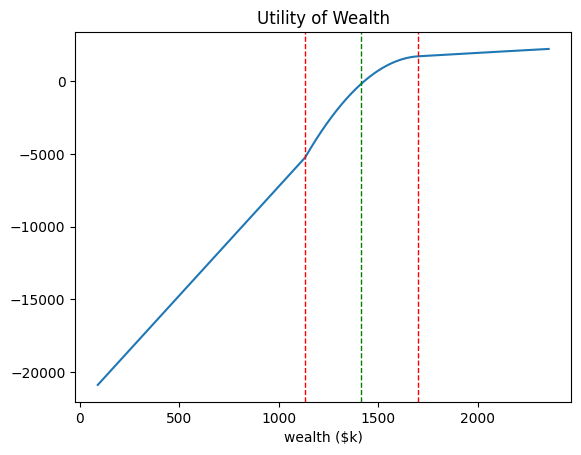

In [22]:
final_wealth = np.round(np.linspace(wealth_bounds.loc[52, 'min_wealth'], wealth_bounds.loc[67, 'max_wealth'], num=n), 3)
util = calc_utility(tgt=target_wealth, x=final_wealth)
wealth_util = pd.Series(index=final_wealth, data=util, name='utility')
wealth_util.index.name = 'wealth ($k)'
ax = wealth_util.plot(title='Utility of Wealth')
ax.axvline(1414, color='green', linestyle='--', linewidth=1)
ax.axvline(1414*.8, color='red', linestyle='--', linewidth=1)
ax.axvline(1414*1.2, color='red', linestyle='--', linewidth=1)

In [23]:
r_all = fund_stats.loc[:, 'Return'].values
sigma_all = fund_stats.loc[:, 'Risk'].values

In [24]:
def calc_expected_utility_vectorized(w_0, cf_0, r_0, sigma_0):
    rounding_multiplier = (1000/PRECISION)
    w_1_max = np.ceil((w_0 + cf_0) * (1+(r_0+(sigma_0*N_SIGMA))) * rounding_multiplier)/rounding_multiplier
    w_1_min = np.floor((w_0 + cf_0) * (1+(r_0-(sigma_0*N_SIGMA))) * rounding_multiplier)/rounding_multiplier    
    
    num = int((w_1_max.max() - w_1_min.min()) * 10**(SIG_DIGITS))
    # print(num)
    samples = np.linspace(start=-1*N_SIGMA, stop=N_SIGMA, num=num)
    # adjust the sample mean
    samples = samples - samples.mean()
    
    cdf = norm.cdf(x=samples, loc=0, scale=1)
    probability = np.append(cdf[0], cdf[1:] - cdf[:-1])
    
    mix_adjusted_samples = np.outer(samples, sigma_0) + np.tile(r_0, (num, 1))
    
    w_1 = np.round((w_0 + cf_0) * (1+mix_adjusted_samples).astype(np.double), SIG_DIGITS)

    # ALL_TIME_MAX['value'] = np.maximum(w_1.max(), ALL_TIME_MAX['value'])
    
    util_w_1 = calc_utility(tgt=target_wealth, x=w_1)
    
    exp_u = util_w_1.T @ probability
    return exp_u

def vectorized_func_wrapper(row: dict) -> float:
    """
    wrapper func for expected utility calculation
    """
    return calc_expected_utility_vectorized(
        w_0=row['W'], 
        cf_0=cf_uniform.loc[row['Age']], 
        r_0=r_all, 
        sigma_0=sigma_all,
    )

## pandas

In [25]:
ages = np.array(range(retirement_age - 15, retirement_age))
ages

cols = ['Age', 'W']
frames = []
mixes = np.array(range(8))+1
for current_age in ages:
    min_bound = wealth_bounds.loc[current_age, 'min_wealth']
    max_bound = wealth_bounds.loc[current_age, 'max_wealth']
    frames.append(pd.DataFrame(itertools.product([current_age], wealth_util.loc[min_bound:max_bound].index), columns=cols))
result = pd.concat(frames) 
result.shape

(25898, 2)

In [26]:
start = time.time()
result['Exp_U_All_Mixes'] = result.apply(vectorized_func_wrapper, axis=1)
end = time.time()
print(f'Runtime: {end-start}')

result['E[U]'] = result['Exp_U_All_Mixes'].apply(np.max)
result['Mix'] = result['Exp_U_All_Mixes'].apply(np.argmax) + 1

Runtime: 69.37754774093628


In [27]:
cols = ['Name', 'Age', 'W', 'Mix', 'Return', 'Risk', 'W_1', 'E[U]']
investment_plan = pd.DataFrame(columns=cols)
for ix, row in clients.iterrows():
    row = clients.loc[ix]
    w_0 = row['CurrentValue']
    ages = np.array(range(int(row['Age']), retirement_age))
    for age in ages:        
        #
        w_0 = round(w_0 + cf_uniform.loc[age], 0)
        #
        max_row = result[(result['Age'] == age) & (result['W'] == w_0)]
        mix = np.nan if max_row.shape[0] == 0 else max_row['Mix'].item()
        e_u = max_row['E[U]'].item()
        #
        fund = fund_stats.loc[f'Mix{mix}']
        r = fund['Return']
        sigma = fund['Risk']
        w_1 = w_0 * (1 + r)
        #
        investment_plan.loc[len(investment_plan)] = [ix, age, w_0, mix, r, sigma, w_1, e_u]
        w_0 = w_1

In [28]:
pctl = [0.95, 0.75, 0.5, 0.25, 0.05]
conf = pd.Series(index=pctl, data=norm.ppf(pctl))

confidence_bands = investment_plan.copy()
confidence_bands = confidence_bands.set_index(['Name', 'Age'])[['Return', 'Risk']].unstack('Name')

confidence_bands.loc[:, idx['Return', :]] = confidence_bands.loc[:, idx['Return', :]].add(1)#.cumprod()
confidence_bands.loc[:, idx['Risk', :]] = confidence_bands.loc[:, idx['Risk', :]].pow(2).cumsum().pow(1/2)

confidence_bands = confidence_bands.stack('Name').join(investment_plan.set_index(['Name', 'Age']).W).reset_index().set_index(['Name', 'Age']).sort_index()

cols = []
for pctl, zscore in conf.items():
    col_name = f'{int((1-pctl)*100)}%'
    cols.append(col_name)
    confidence_bands[col_name] = (confidence_bands.Return + confidence_bands.Risk*zscore) * confidence_bands.W

C:\Users\yrevtsov\AppData\Local\Temp\ipykernel_1588\746100261.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  confidence_bands = confidence_bands.stack('Name').join(investment_plan.set_index(['Name', 'Age']).W).reset_index().set_index(['Name', 'Age']).sort_index()


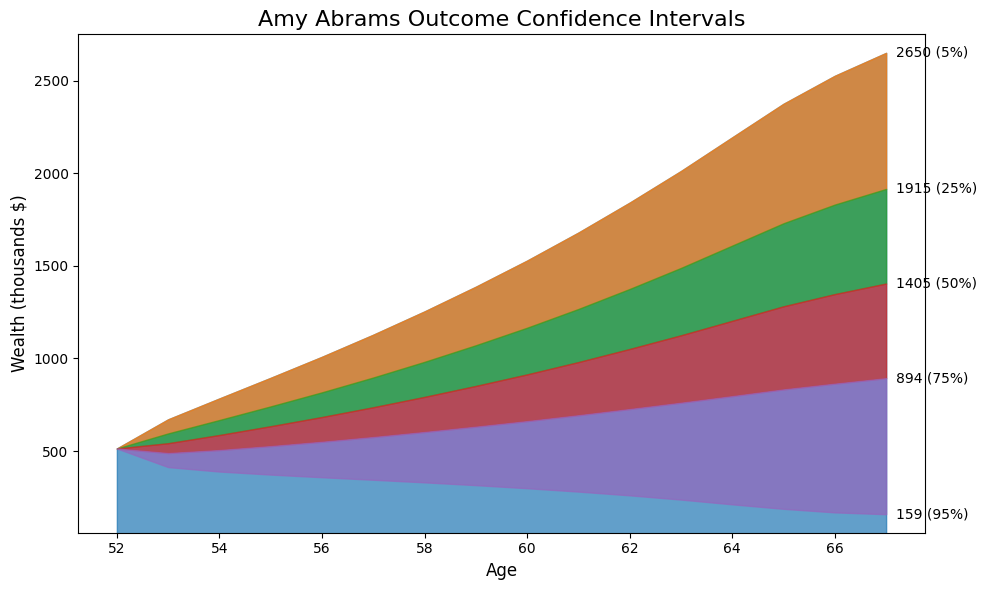

In [30]:
name = 'Amy Abrams'
cumulative = confidence_bands.loc[name][cols]
cumulative.index += 1
cumulative.loc[clients.loc[name, 'Age'], cols] = investment_plan[(investment_plan.Name == name) & (investment_plan.Age == clients.loc[name, 'Age'])].W.item()
cumulative.sort_index(inplace=True)

plt.figure(figsize=(10, 6))

colors = plt.cm.tab10.colors  # Choose a colormap for better visuals
last_x = cumulative.index[-1]
for i, col in enumerate(cumulative.columns):
    if i == 0:  # Bottom area
        plt.fill_between(cumulative.index, 0, cumulative[col], label=col, color=colors[i % len(colors)], alpha=0.7)
    else:  # Other stacked areas
        plt.fill_between(cumulative.index, cumulative.iloc[:, i - 1], cumulative[col], label=col, color=colors[i % len(colors)], alpha=0.7)

    # Position for the label
    last_x = cumulative.index[-1]
    last_y = cumulative.iloc[-1, i]  # Last value in the cumulative series
    
    plt.text(
        last_x + 0.2, last_y - 0.1,  # Slight offset for better visibility
        f"{last_y:.0f} ({col})",
        fontsize=10,
        # color=colors[i % len(colors)],
        va='center'
    )
    
plt.ylim(cumulative.min().min() - 100, cumulative.max().max() + 100) 
    
# Add labels and legend
plt.title(f'{name} Outcome Confidence Intervals', fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Wealth (thousands $)", fontsize=12)
# plt.legend(title="Areas", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

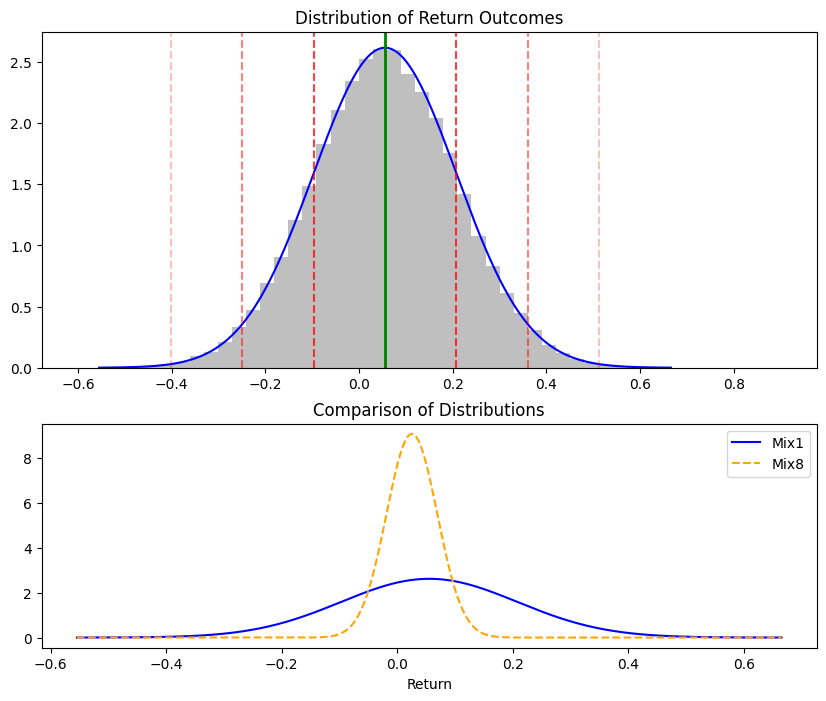

In [36]:
# Inputs
mean = fund_stats.loc['Mix1', 'Return']
std_dev = fund_stats.loc['Mix1', 'Risk']

mean2 = fund_stats.loc['Mix8', 'Return']
std_dev2 = fund_stats.loc['Mix8', 'Risk']

# Generate sample data
sample_size = 100000
data = np.random.normal(loc=mean, scale=std_dev, size=sample_size)

# Set the figure size
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 2]})

# Create a histogram of the data
axs[0].hist(data, bins=50, density=True, alpha=0.5, color='gray', label='Histogram')

# Generate the x values for the PDF line
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
pdf = norm.pdf(x, loc=mean, scale=std_dev)

# Plot the PDF
axs[0].plot(x, pdf, color='blue', label='PDF (Normal Curve)')


# Add a vertical green line for the center (mean)
axs[0].axvline(mean, color='green', linestyle='-', linewidth=2, label='Mean')

# Add vertical lines for 1, 2, and 3 standard deviations, getting lighter further from the mean
for i in range(1, 4):
    alpha = 1 - i * 0.25  # Reduce alpha for lighter lines
    axs[0].axvline(mean + i * std_dev, color='red', linestyle='--', alpha=alpha, label=f'+{i} Std Dev' if i == 1 else None)
    axs[0].axvline(mean - i * std_dev, color='red', linestyle='--', alpha=alpha, label=f'-{i} Std Dev' if i == 1 else None)

# Add labels, title, and legend
axs[0].set_title('Distribution of Return Outcomes')
# axs[0].set_xlabel('Return')
# axs[0].set_ylabel('Density')

# Bottom Plot: Comparison of two normal distributions
x2 = np.linspace(min(mean - 4*std_dev, mean2 - 4*std_dev2), 
                 max(mean + 4*std_dev, mean2 + 4*std_dev2), 
                 1000)

# PDF of the second distribution
pdf2 = norm.pdf(x2, loc=mean2, scale=std_dev2)
axs[1].plot(x, pdf, color='blue', label='Mix1')
axs[1].plot(x2, pdf2, color='orange', linestyle='--', label='Mix8')

axs[1].set_title('Comparison of Distributions')
axs[1].set_xlabel('Return')
axs[1].legend()

# Show the plot
plt.show()

In [74]:
eg = result[(result.Age == 52) & (result.W == 514)]

mc = [f'Mix{i+1}' for i in range(8)]


eg[mc] = eg['Exp_U_All_Mixes'].tolist()

fund_stats.index.name = 'Fund'

eg = eg.set_index(['Age', 'W'])[mc].stack().round(1)
eg.index.names = ['Age', 'W', 'Fund']
eg.name = 'E[U]'
eg = eg.to_frame().join(fund_stats)
eg.loc[:, ['Risk', 'Return']] = eg.loc[:, ['Risk', 'Return']].astype(float).mul(100).round(2)

C:\Users\yrevtsov\AppData\Local\Temp\ipykernel_1588\2640751305.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eg[mc] = eg['Exp_U_All_Mixes'].tolist()
C:\Users\yrevtsov\AppData\Local\Temp\ipykernel_1588\2640751305.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eg[mc] = eg['Exp_U_All_Mixes'].tolist()
C:\Users\yrevtsov\AppData\Local\Temp\ipykernel_1588\2640751305.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [76]:
eg.reset_index()

,Age,W,Fund,E[U],Return,Risk
0,52,514.0,Mix1,-13871.8,5.54,15.25
1,52,514.0,Mix2,-13899.2,5.13,13.5
2,52,514.0,Mix3,-13931.3,4.73,11.96
3,52,514.0,Mix4,-13963.4,4.33,10.47
4,52,514.0,Mix5,-13998.0,3.9,8.83
5,52,514.0,Mix6,-14031.0,3.48,7.31
6,52,514.0,Mix7,-14065.6,3.04,5.81
7,52,514.0,Mix8,-14105.9,2.54,4.4
